<a href="https://colab.research.google.com/github/jessebuyungo/yield_prediction/blob/main/Ibuga_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install fusets

In [1]:
import fusets

In [ ]:
import ee
import geemap

In [4]:
import pandas as pd

In [5]:

data = pd.read_csv('Ibuga.csv')
data.head()
data = data.rename(columns={'date': 'time'})

data

,NDVI,time
0,0.624363,2002-04-02
1,0.738515,2002-05-20
2,0.529325,2002-06-05
3,0.307242,2002-07-23
4,0.504398,2002-09-09
...,...,...
738,0.596885,2024-12-12
739,0.593803,2024-12-17
740,0.674030,2024-12-18
741,0.647100,2024-12-22


In [6]:
import numpy as np

In [7]:
numpy_dates    =  []
numpy_ndvi     =  []
easting        =  []
northing       =  []

for i in range(len(data)):
    east =np.array(4000)
    north = np.array(1000)
    m1= np.datetime64(data['time'][i])
    m2= np.array(data['NDVI'][i])
    numpy_dates.append(m1)
    numpy_ndvi.append(m2)
    easting.append(east)
    northing.append(north)

v1= np.array(1000)
v2= np.array(4000)





In [8]:
import xarray as xr

In [9]:
ndvi_xr = xr.DataArray(
    data=numpy_ndvi,
    coords={'time': numpy_dates,

            },
    dims=['time' ],


)




/tmp/ipython-input-2125767148.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ndvi_xr = xr.DataArray(


In [10]:
from fusets import WhittakerTransformer as Tr
transformer = Tr()

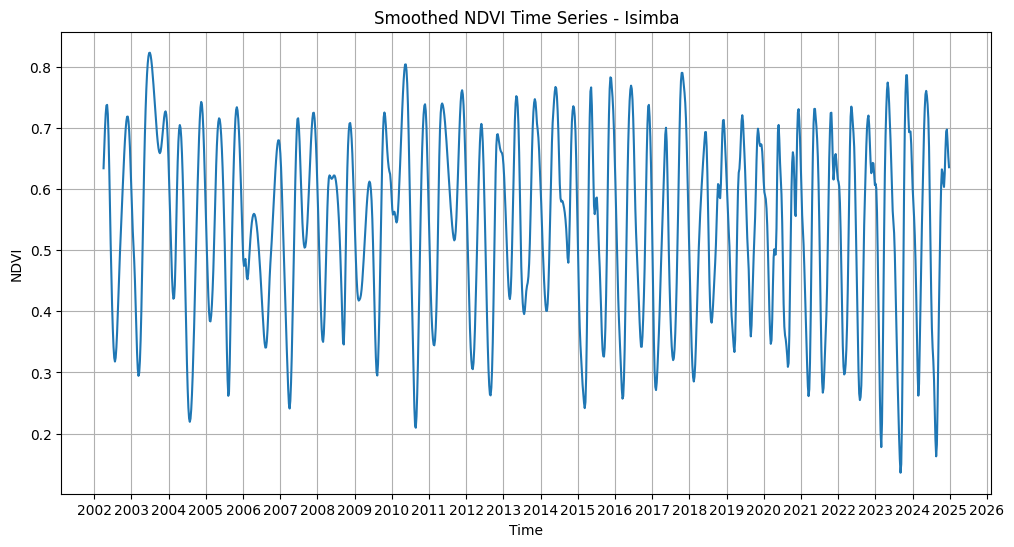

In [11]:
transformed_X = transformer.fit_transform(ndvi_xr,
                                          smoothing_lambda=1000,
                                          time_dimension = 'time',
                                          prediction_period='P7D')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import mdates

# Plot the transformed NDVI data. Ensure 'transformed_X' is defined in a previous cell.
plt.figure(figsize=(12, 6))
plt.plot(transformed_X['time'],np.array(transformed_X), label ='smothed ndvi')
plt.title('Smoothed NDVI Time Series - Isimba')


plt.xlabel('Time')
plt.ylabel('NDVI')
plt.grid(True)


# Set the x-axis to show yearly markings
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

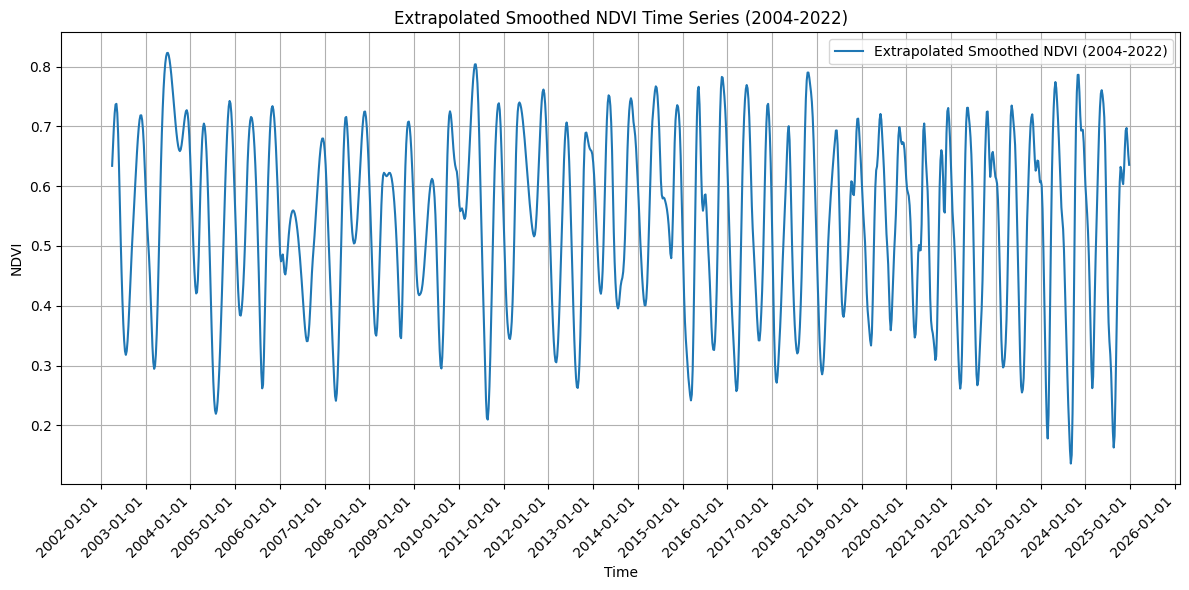

In [12]:
# Select data from 2004 to 2022
extrapolated_X_subset = transformed_X.sel(time=slice('2002', '2024'))

# Plot the subset of the extrapolated NDVI data
plt.figure(figsize=(12, 6))
extrapolated_X_subset.plot(label='Extrapolated Smoothed NDVI (2004-2022)')

plt.title('Extrapolated Smoothed NDVI Time Series (2004-2022)')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.grid(True)

# Optional: Improve x-axis formatting for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # More detailed date format
plt.xticks(rotation=45, ha='right') # Rotate date labels for readability

plt.legend()
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

Compute peaks

In [73]:
from fusets.analytics import phenology as ph
from fusets.peakvalley import peakvalley as pk
#result = ph(transformed_X)
peaks = pk(extrapolated_X_subset,drop_thr=0.15, rec_r=0.25, slope_thr=-0.007)


In [74]:
# Filter peaks where the NDVI value is equal to 0
peaks_at_zero_ndvi = peaks.where(peaks == -1, drop=True)
valley = peaks.where(peaks == 1, drop=True)

len(valley)

45

In [75]:

dates_see = peaks_at_zero_ndvi['time']


dates_valley = valley['time']



In [76]:
# Add an attribute 'period' with value 'SOS' to dates_valley
start = pd.DataFrame(dates_valley, columns=['time'])
start['period'] = 'EOS'


end= pd.DataFrame(dates_see, columns=['time'])
end['period'] = 'SOS'

all_marked_dates = pd.concat([start, end] )
#all_marked_dates.rename(columns={'': 'time'}, inplace=True)
all_marked_dates = all_marked_dates.sort_values(by='time')
all_marked_dates.head()




,time,period
0,2002-05-21,EOS
0,2002-07-23,SOS
1,2003-02-04,EOS
1,2003-03-11,SOS
2,2003-07-15,EOS


In [77]:
season_lengths = []
start_date = None

for index, row in all_marked_dates.iterrows():
    if row['period'] == 'SOS':
        start_date = row['time']
    elif row['period'] == 'EOS' and start_date is not None:
        end_date = row['time']
        season_length = end_date - start_date
        season_lengths.append({'start_date': start_date, 'end_date': end_date, 'length': season_length})
        start_date = None # Reset start_date after finding an EOS

season_lengths_df = pd.DataFrame(season_lengths)

print("Computed season lengths:")
display(season_lengths_df)

Computed season lengths:


,start_date,end_date,length
0,2002-07-23,2003-02-04,196 days
1,2003-03-11,2003-07-15,126 days
2,2003-10-07,2004-01-06,91 days
3,2004-02-17,2004-05-25,98 days
4,2004-07-27,2005-01-04,161 days
5,2005-02-15,2005-07-05,140 days
6,2005-08-09,2005-12-06,119 days
7,2006-02-14,2006-06-06,112 days
8,2006-08-08,2007-02-20,196 days
9,2007-04-03,2007-07-10,98 days


In [72]:
# Save the DataFrame as an HTML file
# Assuming 'season_lengths_df' is the DataFrame you want to save
html_output = season_lengths_df.to_html()

with open('season_lengths_method_2.html', 'w') as f:
    f.write(html_output)

print("DataFrame saved as season_lengths.html")

DataFrame saved as season_lengths.html


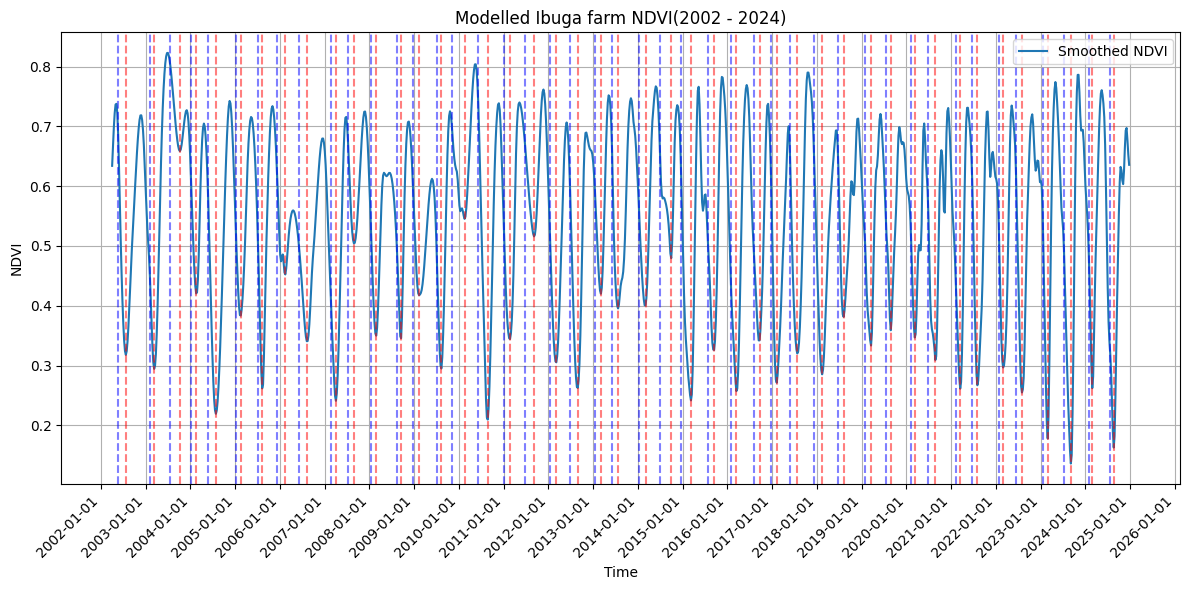

In [51]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the smoothed NDVI time series
plt.figure(figsize=(12, 6))
transformed_X.plot(label='Smoothed NDVI')


# Mark the dates from dates_see with vertical lines
# Need to get the corresponding NDVI values for dates_see from the smoothed data for plotting
# However, vlines is simpler to just mark the dates on the x-axis
#for date in dates_see.values:
  #  plt.axvline(date, color='red', linestyle='--', alpha=0.7) # Use axvline for vertical lines

# Mark the dates from dates_valley with vertical lines
for date in dates_valley.values:
    plt.axvline(date, color='blue', linestyle='--', alpha=0.5) # Use axvline for vertical lines

for date in dates_see .values:
    plt.axvline(date, color='red', linestyle='--', alpha=0.5) # Use axvline for vertical lines

plt.title('Modelled Ibuga farm NDVI(2002 - 2024)')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.grid(True)

# Optional: Improve x-axis formatting for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # More detailed date format
plt.xticks(rotation=45, ha='right') # Rotate date labels for readability

plt.legend()
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

**------------------Phenology-------------------------**

**------------------Median_values-computation----------**